Hardware Preview

In [1]:
!lscpu
# Expect Intel Xeon Chip @2.0Ghz with 2 cores 4 threads, 2xT4 wont give you this much CPU power, but more GPU power in predicting samples.
!nvidia-smi 
# nVidia P100 expected, 2xT4 requires setup encode_multi_process, read it here https://www.sbert.net/docs/package_reference/SentenceTransformer.html
!python -V 
# Python 3.7.12
!cmake --version
# cmake version 3.22.5
!nvcc --version

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          2
On-line CPU(s) list:             0,1
Thread(s) per core:              2
Core(s) per socket:              1
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           85
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:                        3
CPU MHz:                         2000.186
BogoMIPS:                        4000.37
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       32 KiB
L1i cache:                       32 KiB
L2 cache:                        1 MiB
L3 cache:                        38.5 MiB
NUMA node0 CPU(s):               0,1
Vulnerability 

Install needed library

In [2]:
!pip install -q visen
!pip install -q sentence-transformers
!pip install -q "modin[all]"
!pip install -q onnx
!pip install -q onnxruntime

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3

In [3]:
# !pip install -q pyvi
# !pip install -q pretty-confusion-matrix
# !pip install -q Cython
# !pip uninstall -q -y lightgbm
# !apt-get -q install -y libboost-all-dev
# !git clone --quiet --recursive https://github.com/Microsoft/LightGBM
# !git clone --quiet https://github.com/coccoc/coccoc-tokenizer.git

# !cd coccoc-tokenizer/ && mkdir build
# !cd coccoc-tokenizer/ && cd build && cmake -DBUILD_PYTHON=1 ..
# !cd coccoc-tokenizer/ && cd build && make install
# !cd coccoc-tokenizer/python && python setup.py install

# !cd LightGBM/ && rm -r build
# !cd LightGBM/ && mkdir build
# !cd LightGBM/ && cd build && cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
# !cd LightGBM/ && cd build && make -j$(nproc)
# !cd LightGBM/python-package/;python setup.py install --precompile
# !mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
# !rm -r LightGBM

In [4]:
!pip freeze > requirements.txt

In [4]:
import re
from unicodedata import normalize
from string import punctuation
import visen
import pickle

import gc
import warnings
warnings.filterwarnings("ignore")
import scipy
import sys
import os
from time import time

os.environ["MODIN_ENGINE"] = "dask"
os.environ["MODIN_CPUS"] = "16"
# import pandas as pd
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

import torch
from torch import optim
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# from CocCocTokenizer import PyTokenizer
# tokenizer = PyTokenizer(load_nontone_data=True).word_tokenize
# import lightgbm as lgb
# from pretty_confusion_matrix import pp_matrix


In [5]:
opening_ls = ['[', '{', '⁅', '〈', '⎡', '⎢', '⎣', '⎧', '⎨', '⎩', '❬', '❰', '❲', '❴', '⟦', '⟨', '⟪', '⟬', '⦃', '⦇', '⦉',
              '⦋', '⦍', '⦏', '⦑', '⦓', '⦕', '⦗', '⧼', '⸂', '⸄', '⸉', '⸌', '⸜', '⸢', '⸤', '⸦', '〈', '《', '「', '『',
              '【', '〔', '〖', '〘', '〚', '﹛', '﹝', '［', '｛', '｢', '｣']

closing_ls = [']', '}', '⁆', '〉', '⎤', '⎥', '⎦', '⎫', '⎬', '⎭', '❭', '❱', '❳', '❵', '⟧', '⟩', '⟫', '⟭', '⦄', '⦈', '⦊',
              '⦌', '⦎', '⦐', '⦒', '⦔', '⦖', '⦘', '⧽', '⸃', '⸅', '⸊', '⸍', '⸝', '⸣', '⸥', '⸧', '〉', '》', '」', '』',
              '】', '〕', '〗', '〙', '〛', '﹜', '﹞', '］', '｝', '｣']

opening_bracket = {key: '(' for key in opening_ls}
closing_bracket = {key: ')' for key in closing_ls}

opening_bracket_pattern = {f"\\{key}": "(" for key in opening_ls}
closing_bracket_pattern = {f"\\{key}": ")" for key in closing_ls}

### constant
PUNC = '!\"#$&()*+,-–−./:;=?@[\]^_`{|}~”“`°²ˈ‐ㄧ‛∼’'  # remove <> for number_sym and unknown_sym
re_num_and_decimal = '[0-9]*[,.\-]*[0-9]*[,.\-]*[0-9]*[.,\-]*[0-9]*[,.\-]*[0-9]+[.,]?'
re_unknown = '[a-z]+[\d]+[\w]*|[\d]+[a-z]+[\w]*'
re_vnese_txt = r'[^a-z0-9A-ZàáãạảăắằẳẵặâấầẩẫậèéẹẻẽêềếểễệđìíĩỉịòóõọỏôốồổỗộơớờởỡợùúũụủưứừửữựỳỵỷỹýÀÁÃẠẢĂẮẰẲẴẶÂẤẦẨẪẬÈÉẸẺẼÊỀẾỂỄỆĐÌÍĨỈỊÒÓÕỌỎÔỐỒỔỖỘƠỚỜỞỠỢÙÚŨỤỦƯỨỪỬỮỰỲỴỶỸÝ\s|_]'
special_punc = {'”': '"', '': '', "’": "'", "`": "'"}


def sizeof_fmt(num, suffix='B'):
    '''
    Utility function to quickly view memory usage
    :arg num: number of bytes
    :arg suffix: suffix of the number
    :return: string of the number with suffix

    by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified
    '''
    for unit in ['', 'Ki', 'Mi', 'Gi', 'Ti', 'Pi', 'Ei', 'Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def replace_all(replacer: dict, txt: str) -> str:
    """
    Replace all the keys in the dictionary with their respective values.
    :param replacer: dictionary of keys are the words to be replaced and values are the words to replace them with
    :param txt: subject string
    :return: string after replacement
    """
    for old, new in replacer.items():
        txt = txt.replace(old, new)
    return txt


def replace_num(txt: str) -> str:
    """
    Replace all the numbers in the text with blank
    :param text: subject string
    :return: string after replacement
    """
    text = re.sub(re_num_and_decimal, '', txt)
    return text


def replace_unknown(text: str) -> str:
    """
    Replace all the predefined unknown symbols in the text with blank
    :param text: subject string
    :return: string after replacement
    """
    text = re.sub(re_unknown, '', text)
    return text


def unicode_normalizer(text, forms: list = ['NFKC', 'NKFD', 'NFC', 'NFD']) -> str:
    """
    Normalize unicode text
    :param text: subject string
    :param forms: unicode normalization forms
    :return: string after normalization
    """
    for form in forms:
        text = normalize(form, text)
    return text


def normalize_bracket(text: str) -> str:
    """
    Normalize brackets in the text with predefined string for later use
    :param text: subject string
    :return: transformed string
    """
    text = replace_all(opening_bracket, text)
    text = replace_all(closing_bracket, text)
    text = re.sub(r"[\(\[].*?[\)\]]", "", text)
    return text


def remove_punc(text: str) -> str:
    """
    Remove punctuations in the text
    :param text: subject string
    :return: string after removal
    """
    r = re.compile(r'[\s{}]+'.format(re.escape(PUNC)))
    text = r.split(text)
    return ' '.join(i for i in text if i)


def norm(text: str) -> str:
    """
    Normalize text by removing punctuations, numbers, unknown symbols, brackets, and normalize unicode
    :param text: subject string
    :return: normalized string
    """
    text = str(text)
    text = text.lower()
    text = text.split('\n')[0]
    text = unicode_normalizer(text, ["NFKC", "NFKD", "NFD", "NFC"])
    text = replace_all(special_punc, text)
    text = normalize_bracket(text)
    text = replace_unknown(text)
    text = replace_num(text)
    text = remove_punc(text)
    text = re.sub(re_vnese_txt, "", text)
    text = text.strip()
    return visen.clean_tone(text)

In [6]:
sample_txts = [
    '〖𝔰𝔬𝔪𝔢 𝔣𝔞𝔫𝔠𝔶 𝔭𝔯𝔬𝔡𝔲𝔠𝔱 𝔫𝔞𝔪𝔢〗',
    '𝖘𝖔𝖒𝖊 𝖋𝖆𝖓𝖈𝖞 𝖕𝖗𝖔𝖉𝖚𝖈𝖙 𝖓𝖆𝖒𝖊',
    '❰some product code which will overfit this sample❱ 𝓼𝓸𝓶𝓮 𝓯𝓪𝓷𝓬𝔂 𝓹𝓻𝓸𝓭𝓾𝓬𝓽 𝓷𝓪𝓶𝓮',
    '𝓈𝑜𝓂𝑒 𝒻𝒶𝓃𝒸𝓎 𝓅𝓇𝑜𝒹𝓊𝒸𝓉 𝓃𝒶𝓂𝑒',
    '{𝕤𝕠𝕞𝕖 𝕗𝕒𝕟𝕔𝕪 𝕡𝕣𝕠𝕕𝕦𝕔𝕥 𝕟𝕒𝕞𝕖',
    '☯😝ｓｏｍｅ ｆａｎｃｙ ｐｒｏｄｕｃｔ ｎａｍｅ☯😝',
    '𝐬𝐨𝐦𝐞 𝐟𝐚𝐧𝐜𝐲 𝐩𝐫𝐨𝐝𝐮𝐜𝐭 𝐧𝐚𝐦𝐞',
    '𝘀𝗼𝗺𝗲 𝗳𝗮𝗻𝗰𝘆 𝗽𝗿𝗼𝗱𝘂𝗰𝘁 𝗻𝗮𝗺𝗲',
    '𝘴𝘰𝘮𝘦 𝘧𝘢𝘯𝘤𝘺 𝘱𝘳𝘰𝘥𝘶𝘤𝘵 𝘯𝘢𝘮𝘦',
    '▄▀▄▀▄▀ 𝙨𝙤𝙢𝙚 𝙛𝙖𝙣𝙘𝙮 𝙥𝙧𝙤𝙙𝙪𝙘𝙩 𝙣𝙖𝙢𝙚 ▄▀▄▀▄▀',
    '🌌  🎀 𝚜𝚘𝚖𝚎 𝚏𝚊𝚗𝚌𝚢 𝚙𝚛𝚘𝚍𝚞𝚌𝚝 𝚗𝚊𝚖𝚎🌌  🎀 ',
    '(っ◔◡◔)っ ♥ some fancy product name ♥',
]

for sample in sample_txts:
    print(f'sample \"{sample}\", after normalize: \"{norm(sample)}\"')

sample "〖𝔰𝔬𝔪𝔢 𝔣𝔞𝔫𝔠𝔶 𝔭𝔯𝔬𝔡𝔲𝔠𝔱 𝔫𝔞𝔪𝔢〗", after normalize: ""
sample "𝖘𝖔𝖒𝖊 𝖋𝖆𝖓𝖈𝖞 𝖕𝖗𝖔𝖉𝖚𝖈𝖙 𝖓𝖆𝖒𝖊", after normalize: "some fancy product name"
sample "❰some product code which will overfit this sample❱ 𝓼𝓸𝓶𝓮 𝓯𝓪𝓷𝓬𝔂 𝓹𝓻𝓸𝓭𝓾𝓬𝓽 𝓷𝓪𝓶𝓮", after normalize: "some fancy product name"
sample "𝓈𝑜𝓂𝑒 𝒻𝒶𝓃𝒸𝓎 𝓅𝓇𝑜𝒹𝓊𝒸𝓉 𝓃𝒶𝓂𝑒", after normalize: "some fancy product name"
sample "{𝕤𝕠𝕞𝕖 𝕗𝕒𝕟𝕔𝕪 𝕡𝕣𝕠𝕕𝕦𝕔𝕥 𝕟𝕒𝕞𝕖", after normalize: "some fancy product name"
sample "☯😝ｓｏｍｅ ｆａｎｃｙ ｐｒｏｄｕｃｔ ｎａｍｅ☯😝", after normalize: "some fancy product name"
sample "𝐬𝐨𝐦𝐞 𝐟𝐚𝐧𝐜𝐲 𝐩𝐫𝐨𝐝𝐮𝐜𝐭 𝐧𝐚𝐦𝐞", after normalize: "some fancy product name"
sample "𝘀𝗼𝗺𝗲 𝗳𝗮𝗻𝗰𝘆 𝗽𝗿𝗼𝗱𝘂𝗰𝘁 𝗻𝗮𝗺𝗲", after normalize: "some fancy product name"
sample "𝘴𝘰𝘮𝘦 𝘧𝘢𝘯𝘤𝘺 𝘱𝘳𝘰𝘥𝘶𝘤𝘵 𝘯𝘢𝘮𝘦", after normalize: "some fancy product name"
sample "▄▀▄▀▄▀ 𝙨𝙤𝙢𝙚 𝙛𝙖𝙣𝙘𝙮 𝙥𝙧𝙤𝙙𝙪𝙘𝙩 𝙣𝙖𝙢𝙚 ▄▀▄▀▄▀", after normalize: "some fancy product name"
sample "🌌  🎀 𝚜𝚘𝚖𝚎 𝚏𝚊𝚗𝚌𝚢 𝚙𝚛𝚘𝚍𝚞𝚌𝚝 𝚗𝚊𝚖𝚎🌌  🎀 ", after normalize: "some fancy product name"
sample "(っ◔◡◔)っ ♥ some fancy product name ♥", after normalize: "some fancy product name"


Still normalize function but for DataFrame

In [7]:
def dataframe_normalize(df: pd.DataFrame=None) -> pd.DataFrame:
    """
    Normalize dataframe
    :param df: Dataframe to normalize
    :return: Dataframe normalized
    """    
    assert 'sample' in df.columns, f"DataFrame with column name 'sample' expected, got {df.columns} "
    begin = time()

    df['sample'] = df['sample'].str.lower()
    df['sample'] = df['sample'].str.replace('[a-z]+[\d]+[\w]*|[\d]+[a-z]+[\w]*', '', regex=True) # replace all product code with blank
    df['sample'] = df['sample'].str.replace('[0-9]*[,.\-]*[0-9]*[,.\-]*[0-9]*[.,\-]*[0-9]*[,.\-]*[0-9]+[.,]?', '', regex=True) # replace all number with blank
    df['sample'] = df['sample'].replace(opening_bracket_pattern, regex=True) # normalize opening brackets, listed above
    df['sample'] = df['sample'].replace(closing_bracket_pattern, regex=True) # normalize closing brackets, listed above
    df['sample'] = df['sample'].str.replace("[\(\[].*?[\)\]]", '', regex=True) # remove all content inside brackets, eg: (Siêu sale 12/12)
    df['sample'] = df['sample'].str.normalize('NFKC') # Normalize unicode with NFKC standard 
    df['sample'] = df['sample'].str.normalize('NFKD')
    df['sample'] = df['sample'].str.normalize('NFC')
    df['sample'] = df['sample'].str.normalize('NFD')
#   # Remove non Vietnamese text, seems like unessesary right now, might consider remove later to improve run time.
    df['sample'] = df['sample'].str.replace(r"[^a-z0-9A-ZàáãạảăắằẳẵặâấầẩẫậèéẹẻẽêềếểễệđìíĩỉịòóõọỏôốồổỗộơớờởỡợùúũụủưứừửữựỳỵỷỹýÀÁÃẠẢĂẮẰẲẴẶÂẤẦẨẪẬÈÉẸẺẼÊỀẾỂỄỆĐÌÍĨỈỊÒÓÕỌỎÔỐỒỔỖỘƠỚỜỞỠỢÙÚŨỤỦƯỨỪỬỮỰỲỴỶỸÝ\s|_]", '', regex=True)
    df['sample'] = df['sample'].str.replace('đ', 'd').str.strip() # Special case where unicode normalizer does not consider 'đ' a combination of base unicode characters
    print('Total enlapsed time:', time()- begin, 'seconds')
    return df

##### Data preparation

In [8]:
data = pd.read_csv('/kaggle/input/data-dl-final/shopee_data.csv', encoding='utf8', sep='\t')

In [9]:
data = data.sample(frac=1)
data

,sample,label
502001,Set Gucci,Thời trang
307486,🌵Nệm Lót 3 Lớp Mềm Mại Chống Thấm Nước Thoáng ...,Mẹ & Bé
986821,Cốc Nguyệt san lin cúp,unknown
354601,"Sạc máy ảnh CB-2LCE cho Canon NB-10L, Sạc dây",Điện tử - Điện máy
71704,Kem Dưỡng Mắt Đánh Tan Quầng Thâm G9Skin White...,Mỹ phẩm
...,...,...
604181,HD NÚT 19-91 XANH RÊU - M,Thời trang
642301,Viên Hỗ Trợ Sinh Lý Xtrazex - Lên Đỉnh Thăng H...,unknown
931968,Zhao Lusi The same rabbit is suitable for ipho...,Điện tử - Điện máy
208474,Set 10 đầu nối dây cáp âm thanh 2 pin DIN 2-Pin,Điện tử - Điện máy


In [10]:
data = dataframe_normalize(data)
data

Total enlapsed time: 167.3138575553894 seconds


,sample,label
502001,set gucci,Thời trang
307486,nem lot lop mem mai chong tham nuoc thoang kh...,Mẹ & Bé
986821,coc nguyet san lin cup,unknown
354601,sac may anh cb cho canon nb sac day,Điện tử - Điện máy
71704,kem duong mat danh tan quang tham white in mi...,Mỹ phẩm
...,...,...
604181,hd nut xanh reu m,Thời trang
642301,vien ho tro sinh ly xtrazex len dinh thang ho...,unknown
931968,zhao lusi the same rabbit is suitable for max ...,Điện tử - Điện máy
208474,set dau noi day cap am thanh pin din pin,Điện tử - Điện máy


In [11]:
data = data[~(data['label'] == 'unknown')]
data.dropna(inplace=True)
data['label'].value_counts()

Điện tử - Điện máy    260100
Thời trang            196910
Mỹ phẩm               189308
Mẹ & Bé               177787
Name: label, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_val, y_train , y_val = train_test_split(data['sample'], data['label'],train_size=0.7, random_state=42, shuffle=True)

In [14]:
X_train

429613                              sua tam ziaja cho tre em
755127                                          cv ngoc thao
755497                                 khoac long dai tay co
1059193                         bat an dam lua mach kem thia
775816                              ao vest tay nhiu hong  s
                                 ...                        
969306                                               quan lb
592340     wonjin medi hydro vial mask  mat na cap am sau...
399183          set  phu kien ho tro chup anh cho be so sinh
155473                                 set  day buoc cao cap
530097                                      wax long an lanh
Name: sample, Length: 576873, dtype: object

In [15]:
y_train.value_counts()

Điện tử - Điện máy    182373
Thời trang            137775
Mỹ phẩm               132319
Mẹ & Bé               124406
Name: label, dtype: int64

In [16]:
le = LabelEncoder()
y_train = torch.tensor(le.fit_transform(y_train.values)).cuda()
y_val = torch.tensor(le.transform(y_val.values)).cuda()

In [17]:
print(le.inverse_transform([0]))
print(le.inverse_transform([1]))
print(le.inverse_transform([2]))
print(le.inverse_transform([3]))

['Mẹ & Bé']
['Mỹ phẩm']
['Thời trang']
['Điện tử - Điện máy']


In [18]:
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('keepitreal/vietnamese-sbert',device='cuda')

X_train = X_train.tolist()
X_train = embedder.encode(X_train, batch_size=2048)
X_train = torch.from_numpy(X_train).float()


X_val = X_val.tolist()
X_val = embedder.encode(X_val, batch_size=2048)
X_val = torch.from_numpy(X_val).float()


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/752 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/767 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/540M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/895k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

In [35]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),key= lambda x: -x[1])[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            _9: 222.7 MiB
                           _10: 222.7 MiB
                          data: 200.4 MiB
                           _14: 76.4 MiB
                           _i5: 13.1 KiB
                           _i7:  5.7 KiB
                           _i6:  3.6 KiB
                          _i31:  2.9 KiB
                          _i29:  2.9 KiB
                          _i30:  2.9 KiB
               opening_bracket:  2.2 KiB
               closing_bracket:  2.2 KiB
       opening_bracket_pattern:  2.2 KiB
       closing_bracket_pattern:  2.2 KiB
                          _i28:  1.8 KiB
                    DataLoader:  1.4 KiB
           SentenceTransformer:  1.4 KiB
                    Classifier:  1.4 KiB
                  GridSearchCV:  1.0 KiB
               TfidfVectorizer:  1.0 KiB


In [38]:
del data
gc.collect()

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),key= lambda x: -x[1])[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


                            _9: 222.7 MiB
                           _10: 222.7 MiB
                           _14: 76.4 MiB
                           _i5: 13.1 KiB
                           _i7:  5.7 KiB
                           _i6:  3.6 KiB
                          _i31:  2.9 KiB
                          _i29:  2.9 KiB
                          _i30:  2.9 KiB
               opening_bracket:  2.2 KiB
               closing_bracket:  2.2 KiB
       opening_bracket_pattern:  2.2 KiB
       closing_bracket_pattern:  2.2 KiB
                          _i28:  1.8 KiB
                    DataLoader:  1.4 KiB
           SentenceTransformer:  1.4 KiB
                    Classifier:  1.4 KiB
                  GridSearchCV:  1.0 KiB
               TfidfVectorizer:  1.0 KiB
               CountVectorizer:  1.0 KiB


# THIS MODEL IS **EXTREMELY** SIMPLE, TRY TO BUILD A **BIT** MORE COMPLEX MODEL!

In [39]:
BATCHSIZE = 2048
EPOCHS = 20
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [40]:
class DatasetMaper(Dataset):
    def __init__(self, x, y, device='gpu'):
        if not x.is_cuda:
            self.x = x.to(device)
        else:
            self.x = x
        if not y.is_cuda:
            self.y = y.to(device)  
        else:
            self.y = y
            
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [41]:
training_set = DatasetMaper(X_train, y_train, device)
val_set = DatasetMaper(X_val, y_val, device)
train_dataloader = DataLoader(training_set, batch_size=BATCHSIZE, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=BATCHSIZE, shuffle=True)

In [42]:
train_features, train_labels = next(iter(train_dataloader))
train_features.is_cuda

True

In [49]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(768, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 16)
        self.out = nn.Linear(16, len(le.classes_))
        self.dropout = nn.Dropout(0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(16)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.layer1(x)))
        x = self.dropout(x)
        x = self.batchnorm2(F.relu(self.layer2(x)))
        x = self.dropout(x)
        x = self.batchnorm3(F.relu(self.layer3(x)))
        x = self.dropout(x)
        return F.log_softmax(self.out(x), dim=1)


In [50]:
model = Classifier().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [51]:
model

Classifier(
  (layer1): Linear(in_features=768, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=4, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [52]:
next(model.parameters()).is_cuda

True

In [53]:
%%time

total_step = len(train_dataloader)
for epoch in range(1, EPOCHS+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch, EPOCHS, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss, total_t, correct_t = 0,0,0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_dataloader):
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(val_dataloader))
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if batch_loss < valid_loss_min:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'classifier.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1

Epoch [1/20], Step [0/282], Loss: 1.4626
Epoch [1/20], Step [50/282], Loss: 0.9673


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


Epoch [1/20], Step [100/282], Loss: 0.8013


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


Epoch [1/20], Step [150/282], Loss: 0.7263
Epoch [1/20], Step [200/282], Loss: 0.6636


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


Epoch [1/20], Step [250/282], Loss: 0.6238

train loss: 0.8005, train acc: 74.4942


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


validation loss: 0.5591, validation acc: 84.9494

Detected network improvement, saving current model
Epoch 2

Epoch [2/20], Step [0/282], Loss: 0.5907
Epoch [2/20], Step [50/282], Loss: 0.5507


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


Epoch [2/20], Step [100/282], Loss: 0.5356
Epoch [2/20], Step [150/282], Loss: 0.4884


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


Epoch [2/20], Step [200/282], Loss: 0.4743
Epoch [2/20], Step [250/282], Loss: 0.4501


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)



train loss: 0.6510, train acc: 86.2866


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


validation loss: 0.4810, validation acc: 88.6588

Detected network improvement, saving current model
Epoch 3

Epoch [3/20], Step [0/282], Loss: 0.4231


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


Epoch [3/20], Step [50/282], Loss: 0.4099
Epoch [3/20], Step [100/282], Loss: 0.4030


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


Epoch [3/20], Step [150/282], Loss: 0.3610


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


Epoch [3/20], Step [200/282], Loss: 0.3841


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


Epoch [3/20], Step [250/282], Loss: 0.3636

train loss: 0.5623, train acc: 89.0288


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


validation loss: 0.4273, validation acc: 90.4891

Detected network improvement, saving current model
Epoch 4

Epoch [4/20], Step [0/282], Loss: 0.3385


distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


Epoch [4/20], Step [50/282], Loss: 0.3481
Epoch [4/20], Step [100/282], Loss: 0.3163


distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


Epoch [4/20], Step [150/282], Loss: 0.2962


distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


Epoch [4/20], Step [200/282], Loss: 0.3252
Epoch [4/20], Step [250/282], Loss: 0.2944


distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)



train loss: 0.5021, train acc: 90.4806


distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


validation loss: 0.3893, validation acc: 91.4255

Detected network improvement, saving current model
Epoch 5

Epoch [5/20], Step [0/282], Loss: 0.2963


distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


Epoch [5/20], Step [50/282], Loss: 0.2831


distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


Epoch [5/20], Step [100/282], Loss: 0.2731
Epoch [5/20], Step [150/282], Loss: 0.2800


distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


Epoch [5/20], Step [200/282], Loss: 0.2862


distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


Epoch [5/20], Step [250/282], Loss: 0.2781

train loss: 0.4583, train acc: 91.3464


distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


validation loss: 0.3606, validation acc: 92.1936

Detected network improvement, saving current model
Epoch 6

Epoch [6/20], Step [0/282], Loss: 0.2696


distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


Epoch [6/20], Step [50/282], Loss: 0.2406
Epoch [6/20], Step [100/282], Loss: 0.2521


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


Epoch [6/20], Step [150/282], Loss: 0.2589
Epoch [6/20], Step [200/282], Loss: 0.2486


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Epoch [6/20], Step [250/282], Loss: 0.2500

train loss: 0.4246, train acc: 91.9705


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


validation loss: 0.3382, validation acc: 92.6482

Detected network improvement, saving current model
Epoch 7

Epoch [7/20], Step [0/282], Loss: 0.2546


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


Epoch [7/20], Step [50/282], Loss: 0.2488


distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Epoch [7/20], Step [100/282], Loss: 0.2322
Epoch [7/20], Step [150/282], Loss: 0.2141


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


Epoch [7/20], Step [200/282], Loss: 0.2393


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


Epoch [7/20], Step [250/282], Loss: 0.2281

train loss: 0.3979, train acc: 92.3886


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


validation loss: 0.3205, validation acc: 92.9584

Detected network improvement, saving current model
Epoch 8

Epoch [8/20], Step [0/282], Loss: 0.2258


distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Epoch [8/20], Step [50/282], Loss: 0.2267


distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Epoch [8/20], Step [100/282], Loss: 0.2369


distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Epoch [8/20], Step [150/282], Loss: 0.2242


distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Epoch [8/20], Step [200/282], Loss: 0.2386


distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Epoch [8/20], Step [250/282], Loss: 0.2120

train loss: 0.3762, train acc: 92.8000


distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


validation loss: 0.3059, validation acc: 93.1995

Detected network improvement, saving current model
Epoch 9

Epoch [9/20], Step [0/282], Loss: 0.2202


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


Epoch [9/20], Step [50/282], Loss: 0.2304
Epoch [9/20], Step [100/282], Loss: 0.2125


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


Epoch [9/20], Step [150/282], Loss: 0.2140
Epoch [9/20], Step [200/282], Loss: 0.2093


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


Epoch [9/20], Step [250/282], Loss: 0.2059


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)



train loss: 0.3582, train acc: 93.0645


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


validation loss: 0.2936, validation acc: 93.4972

Detected network improvement, saving current model
Epoch 10

Epoch [10/20], Step [0/282], Loss: 0.2255
Epoch [10/20], Step [50/282], Loss: 0.2042


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


Epoch [10/20], Step [100/282], Loss: 0.2132
Epoch [10/20], Step [150/282], Loss: 0.2056


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


Epoch [10/20], Step [200/282], Loss: 0.2213


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


Epoch [10/20], Step [250/282], Loss: 0.1931

train loss: 0.3430, train acc: 93.2576


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


validation loss: 0.2833, validation acc: 93.6080

Detected network improvement, saving current model
Epoch 11

Epoch [11/20], Step [0/282], Loss: 0.1934
Epoch [11/20], Step [50/282], Loss: 0.2183


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


Epoch [11/20], Step [100/282], Loss: 0.2236
Epoch [11/20], Step [150/282], Loss: 0.1885


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


Epoch [11/20], Step [200/282], Loss: 0.1877


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


Epoch [11/20], Step [250/282], Loss: 0.2004

train loss: 0.3299, train acc: 93.4452


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


validation loss: 0.2745, validation acc: 93.7031

Detected network improvement, saving current model
Epoch 12

Epoch [12/20], Step [0/282], Loss: 0.1767


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Epoch [12/20], Step [50/282], Loss: 0.1806


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Epoch [12/20], Step [100/282], Loss: 0.1732
Epoch [12/20], Step [150/282], Loss: 0.1785


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Epoch [12/20], Step [200/282], Loss: 0.1994
Epoch [12/20], Step [250/282], Loss: 0.1866


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)



train loss: 0.3185, train acc: 93.6253


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


validation loss: 0.2667, validation acc: 93.8738

Detected network improvement, saving current model
Epoch 13

Epoch [13/20], Step [0/282], Loss: 0.2094
Epoch [13/20], Step [50/282], Loss: 0.1867


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Epoch [13/20], Step [100/282], Loss: 0.1818


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


Epoch [13/20], Step [150/282], Loss: 0.2026
Epoch [13/20], Step [200/282], Loss: 0.1892


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


Epoch [13/20], Step [250/282], Loss: 0.1635

train loss: 0.3085, train acc: 93.7955


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


validation loss: 0.2600, validation acc: 93.9478

Detected network improvement, saving current model
Epoch 14

Epoch [14/20], Step [0/282], Loss: 0.1648
Epoch [14/20], Step [50/282], Loss: 0.1757


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Epoch [14/20], Step [100/282], Loss: 0.1779
Epoch [14/20], Step [150/282], Loss: 0.1684


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Epoch [14/20], Step [200/282], Loss: 0.1820


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Epoch [14/20], Step [250/282], Loss: 0.1935


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)



train loss: 0.2997, train acc: 93.9208


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


validation loss: 0.2539, validation acc: 94.1128

Detected network improvement, saving current model
Epoch 15

Epoch [15/20], Step [0/282], Loss: 0.1864
Epoch [15/20], Step [50/282], Loss: 0.1900


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Epoch [15/20], Step [100/282], Loss: 0.1904


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Epoch [15/20], Step [150/282], Loss: 0.1744
Epoch [15/20], Step [200/282], Loss: 0.1804


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Epoch [15/20], Step [250/282], Loss: 0.1816

train loss: 0.2917, train acc: 94.0065


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


validation loss: 0.2486, validation acc: 94.1031

Detected network improvement, saving current model
Epoch 16

Epoch [16/20], Step [0/282], Loss: 0.1920
Epoch [16/20], Step [50/282], Loss: 0.1609


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Epoch [16/20], Step [100/282], Loss: 0.1828
Epoch [16/20], Step [150/282], Loss: 0.1975


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Epoch [16/20], Step [200/282], Loss: 0.1806


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Epoch [16/20], Step [250/282], Loss: 0.1797

train loss: 0.2845, train acc: 94.1381


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


validation loss: 0.2438, validation acc: 94.2176

Detected network improvement, saving current model
Epoch 17

Epoch [17/20], Step [0/282], Loss: 0.1673


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Epoch [17/20], Step [50/282], Loss: 0.1839


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Epoch [17/20], Step [100/282], Loss: 0.1838


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


Epoch [17/20], Step [150/282], Loss: 0.1723
Epoch [17/20], Step [200/282], Loss: 0.1891


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


Epoch [17/20], Step [250/282], Loss: 0.1556

train loss: 0.2780, train acc: 94.2426


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


validation loss: 0.2394, validation acc: 94.2835

Detected network improvement, saving current model
Epoch 18

Epoch [18/20], Step [0/282], Loss: 0.1845
Epoch [18/20], Step [50/282], Loss: 0.1739


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


Epoch [18/20], Step [100/282], Loss: 0.1893


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


Epoch [18/20], Step [150/282], Loss: 0.1605


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


Epoch [18/20], Step [200/282], Loss: 0.1958
Epoch [18/20], Step [250/282], Loss: 0.1778


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)



train loss: 0.2721, train acc: 94.3022


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


validation loss: 0.2354, validation acc: 94.3498

Detected network improvement, saving current model
Epoch 19

Epoch [19/20], Step [0/282], Loss: 0.1659
Epoch [19/20], Step [50/282], Loss: 0.1626


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


Epoch [19/20], Step [100/282], Loss: 0.1585


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


Epoch [19/20], Step [150/282], Loss: 0.1918
Epoch [19/20], Step [200/282], Loss: 0.1769


distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


Epoch [19/20], Step [250/282], Loss: 0.1468


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)



train loss: 0.2666, train acc: 94.4359


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


validation loss: 0.2319, validation acc: 94.2940

Epoch 20

Epoch [20/20], Step [0/282], Loss: 0.1696


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


Epoch [20/20], Step [50/282], Loss: 0.1753


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


Epoch [20/20], Step [100/282], Loss: 0.1745
Epoch [20/20], Step [150/282], Loss: 0.1496


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


Epoch [20/20], Step [200/282], Loss: 0.1379


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


Epoch [20/20], Step [250/282], Loss: 0.1894

train loss: 0.2616, train acc: 94.4617


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


validation loss: 0.2285, validation acc: 94.4275

Detected network improvement, saving current model
CPU times: user 3min 12s, sys: 10.2 s, total: 3min 23s
Wall time: 3min 25s


In [59]:
new_sample = ['iphone 13 promax', 'phấn phủ hồng đất', 'áo khoác dạ']

def predict(model, batch, output = 'df', mask_inference=True):
    assert output in ['df', 'dict', 'list']
    batch_sample = [norm(i) for i in batch]
    if mask_inference:
        print(batch_sample)
    
    batch_sample = embedder.encode(batch_sample, batch_size = min(len(batch), 2048))
    batch_sample = torch.from_numpy(batch_sample).float().cuda()

    with torch.no_grad():
        model.eval()
        outputs_t = model(batch_sample)
        _,res = torch.max(outputs_t, dim=1)
        res = [le.inverse_transform([i])[0] for i in res.cpu().numpy()]
    
    
    if output == 'list':
        return res
    
    data_tuple = zip(batch, res)
    
    if output == 'df':
        return pd.DataFrame(data_tuple, columns=['name', 'prediction'])
    
    if output == 'dict':
        return dict(data_tuple)


predict(model, new_sample, output='dict', mask_inference=False)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'iphone 13 promax': 'Điện tử - Điện máy',
 'phấn phủ hồng đất': 'Mỹ phẩm',
 'áo khoác dạ': 'Thời trang'}

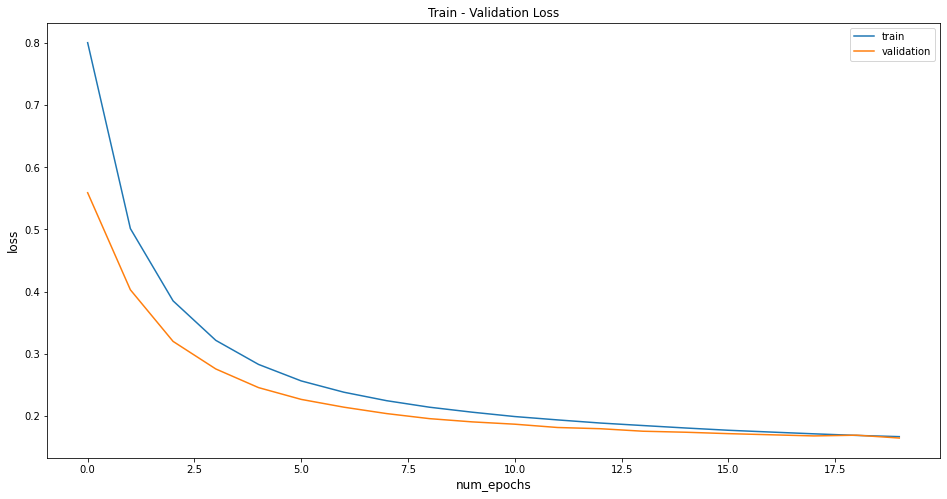

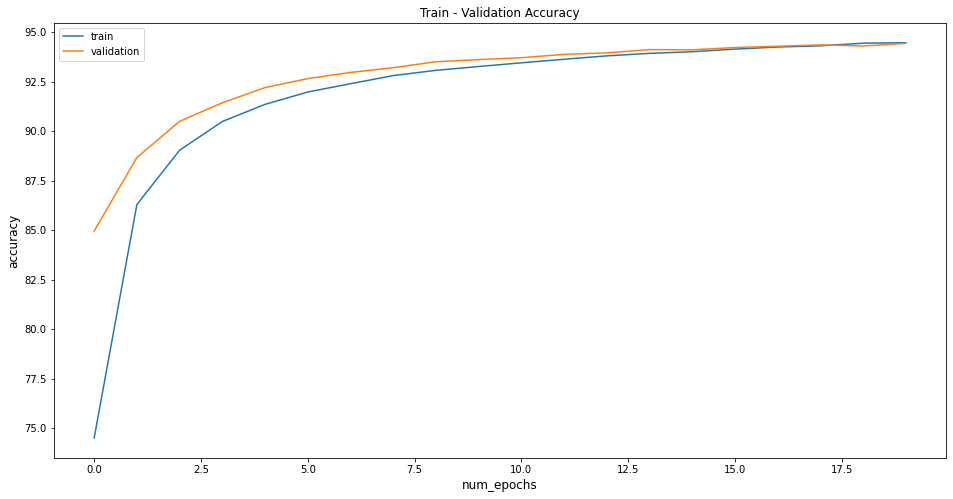

In [89]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,8))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')


fig = plt.figure(figsize=(16,8))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')



In [60]:
df = pd.read_csv('/kaggle/input/data-dl-final/test_DTDM.csv', sep=',', encoding='utf8', on_bad_lines='skip')
test_sample = df.name.to_list()

In [61]:
%%timeit

res = predict(model, test_sample, mask_inference=False)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1.67 s ± 49.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
res = predict(model, test_sample, mask_inference=False)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [63]:
res

,name,prediction
0,Apple Macbook Air 2020 - 13 Inchs (i3-10th/ 8G...,Điện tử - Điện máy
1,Laptop Asus Vivobook X509FJ-EJ053T Core i5-826...,Điện tử - Điện máy
2,Laptop Lenovo Legion Y540-15IRH 81SY0037VN Cor...,Điện tử - Điện máy
3,Laptop Dell Inspiron N3593 70205744 (Core i5-1...,Điện tử - Điện máy
4,Apple Macbook Pro Touch Bar 2019 - 13 inchs (i...,Điện tử - Điện máy
...,...,...
669,Surface Book 2 15 Inch Core I7 Ram 16Gb 512Gb ...,Điện tử - Điện máy
670,Laptop Dell Inspiron 5491 C1JW82 (Core i7-1051...,Điện tử - Điện máy
671,Laptop Asus X409FA-EK469T (Core i3-8145U/ 4G/ ...,Điện tử - Điện máy
672,Laptop Lenovo Thinkpad E15 20RDS0DM00 (Core i5...,Điện tử - Điện máy


In [64]:
res['prediction'].value_counts()

Điện tử - Điện máy    673
Mỹ phẩm                 1
Name: prediction, dtype: int64

In [65]:
wrong_sample = res[res['prediction'] != 'Điện tử - Điện máy']['name'].to_list()
wrong_sample

if wrong_sample:
    print(predict(model, wrong_sample, output = 'dict'))
wrong_sample

['macbook air hàng chính hãng']


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'Macbook Air 2017 MQD32 (13.3 inch) - Hàng Chính Hãng': 'Mỹ phẩm'}


['Macbook Air 2017 MQD32 (13.3 inch) - Hàng Chính Hãng']

In [66]:
random = ['áo choàng đông']
predict(model,random , output = 'dict')

['áo choàng đông']


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'áo choàng đông': 'Thời trang'}

In [67]:
model.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.0180, -0.0394,  0.0012,  ..., -0.0286,  0.0022, -0.0009],
                      [-0.0253, -0.0028,  0.0272,  ..., -0.0138, -0.0253,  0.0188],
                      [ 0.0119,  0.0059,  0.0010,  ..., -0.0059,  0.0051, -0.0136],
                      ...,
                      [-0.0120,  0.0109,  0.0048,  ...,  0.0007,  0.0072,  0.0134],
                      [ 0.0088, -0.0335, -0.0209,  ..., -0.0002, -0.0289, -0.0097],
                      [-0.0304,  0.0235,  0.0177,  ...,  0.0127,  0.0143,  0.0120]],
                     device='cuda:0')),
             ('layer1.bias',
              tensor([-0.0323, -0.0444, -0.0007, -0.0038,  0.0074,  0.0206, -0.0245, -0.0345,
                       0.0057, -0.0014, -0.0100, -0.0193, -0.0288, -0.0215, -0.0145, -0.0037,
                      -0.0094, -0.0133,  0.0136,  0.0148,  0.0068, -0.0014,  0.0070, -0.0297,
                      -0.0025, -0.0078, -0.0088, -0.0177, -0.0316, -0.0389,  0.0166,  

In [68]:
torch.save(model, 'classifier.pt')

In [69]:
import pickle

In [70]:
with open('label_encoder.pkl', 'wb') as encoder:
    pickle.dump(le, encoder)

In [71]:
sample = torch.rand((1, 768), device='cpu')
random_label = torch.randint(low=0, high=3, size=(1,))
# print(sample)
print(random_label)

tensor([0])


In [72]:
randomdata = DatasetMaper(sample, random_label, device = 'cpu')
random_dataloader = DataLoader(randomdata, batch_size=1, shuffle=True)

In [73]:
print(next(model.parameters()).is_cuda)
model = model.to('cpu')
print(next(model.parameters()).is_cuda)

True
False


In [74]:
input_names = ["text_embedding"]
output_names = ["log_softmax"]

In [75]:
model.eval()

Classifier(
  (layer1): Linear(in_features=768, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=4, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [125]:
dynamic_axes={'text_embedding' : {0 : 'batch_size'}, 'log_softmax' : {}}

torch.onnx.export(model, sample, "classifier.onnx", verbose=True, dynamic_axes=dynamic_axes, input_names=input_names, output_names=output_names)

graph(%text_embedding : Float(*, 768, strides=[768, 1], requires_grad=0, device=cpu),
      %layer1.weight : Float(64, 768, strides=[768, 1], requires_grad=1, device=cpu),
      %layer1.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %layer2.weight : Float(64, 64, strides=[64, 1], requires_grad=1, device=cpu),
      %layer2.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %layer3.weight : Float(16, 64, strides=[64, 1], requires_grad=1, device=cpu),
      %layer3.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %out.weight : Float(4, 16, strides=[16, 1], requires_grad=1, device=cpu),
      %out.bias : Float(4, strides=[1], requires_grad=1, device=cpu),
      %batchnorm1.weight : Float(64, strides=[1], requires_grad=1, device=cpu),
      %batchnorm1.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %batchnorm1.running_mean : Float(64, strides=[1], requires_grad=0, device=cpu),
      %batchnorm1.running_var : Float(64, st

In [126]:
import onnx
import onnxruntime as ort
onnx_model = onnx.load("/kaggle/working/classifier.onnx")
onnx.checker.check_model(onnx_model)

In [127]:
del onnx_model

In [128]:
ort_sess = ort.InferenceSession('/kaggle/working/classifier.onnx')
ort_sess.get_profiling_start_time_ns()

0

In [138]:
batch = ['iphone 13', 'ao choang dong']
batch_sample = embedder.encode(batch, batch_size = min(len(batch), 2048))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [140]:
input_name = ort_sess.get_inputs()
label_name = ort_sess.get_outputs()[0].name
outputs = ort_sess.run([label_name], {'text_embedding': batch_sample})
outputs

[array([[-4.9045863e+00, -5.2491827e+00, -6.5992579e+00, -1.4125016e-02],
        [-6.6592479e+00, -7.2042122e+00, -2.6617358e-03, -7.3655767e+00]],
       dtype=float32)]

In [169]:
for index, pred in enumerate(outputs[0]):
    print(index)
    predicted = outputs[0][index].argmax(0)
    print(le.inverse_transform([predicted]))

0
['Điện tử - Điện máy']
1
['Thời trang']
